# En este notebook se hace un análisis avanzado de random forest con la representación vectorial TF-IDF

In [ ]:

%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

import os
from termcolor import colored
import tqdm
import scipy
import gc
import joblib

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab

pylab.rcParams['figure.figsize'] = 6, 4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Cargar los datos desde el archivo JSON
#data_path = '/content/drive/My Drive/proyecto/full_format_recipes.json'  # Clara
data_path = '/content/drive/My Drive/Colab Notebooks/proyecto/full_format_recipes.json'  # Jorge
recipes_df = pd.read_json(data_path)

import scipy.sparse
# Cargamos la matriz TF-IDF
#matriz_tfidf = scipy.sparse.load_npz('/content/drive/My Drive/proyecto/TFIDF.npz')#clara
matriz_tfidf = scipy.sparse.load_npz('/content/drive/My Drive/Colab Notebooks/proyecto/TFIDF.npz')#jorge

# Cargar el vectorizador TF-IDF
tfidf = joblib.load('/content/drive/My Drive/Colab Notebooks/proyecto/tfidf_vectorizer.joblib')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **1. Preparación de los datos de entrenamiento y de test**

In [ ]:
from re import X
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = recipes_df['rating']
print(min(target)) #0
print(max(target)) #5
target = target.fillna(target.mean()) # Relleno los valores que faltan (NaN) con media
# Convertimos el target en variable categórica (valores 0 o 1)
# Dividimos los datos en conjunto de entrenamiento y de test, features (X) y labels (y)

X_train, X_test, y_train, y_test = train_test_split(matriz_tfidf, target, test_size=0.2, random_state=42)

# Reducir el tamaño del conjunto de datos
sample_size = 1000  # Número de muestras
X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train, y_train, train_size=sample_size, random_state=42)

0.0
5.0


### **2. Entrenamiento y evaluación**

#### ***2.1 Modelo de regresión con técnica de librería Scikit Learn***

##### *2.1.3 Random Forest*

In [ ]:
#para random forest no hay que normalizar los datos

In [ ]:
#para que sea más eficiente por la cantidad de datos de entrenamiento
#SelectKBest es una técnica que selecciona las K mejores características de un conjunto de características según un criterio de evaluación. En este caso "f-regression"

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

n_components = 500  # Número de componentes principales que quieres conservar
k_best = SelectKBest(f_regression, k=n_components)  # Selecciona las 500 mejores características

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definir el grid de hiperparámetros
param_grid = {
    'n_estimators': [50,100,150],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo RandomForestRegressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Búsqueda exhaustiva
# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_sampled, y_train_sampled)

# Imprimir los mejores parámetros y la mejor puntuación de validación cruzada

print(f"Mejores parámetros encontrados: {grid_search.best_params_}")
print(f"Mejor puntuación de validación cruzada: {grid_search.best_score_}")

# Mejor modelo
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Mejores parámetros encontrados: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
Mejor puntuación de validación cruzada: 0.08215699847275566


In [ ]:
#aquí lo entreno con los hiperparametros fijado excepto el del nº de arboles de decisión al que
#mejor resultado obtenido

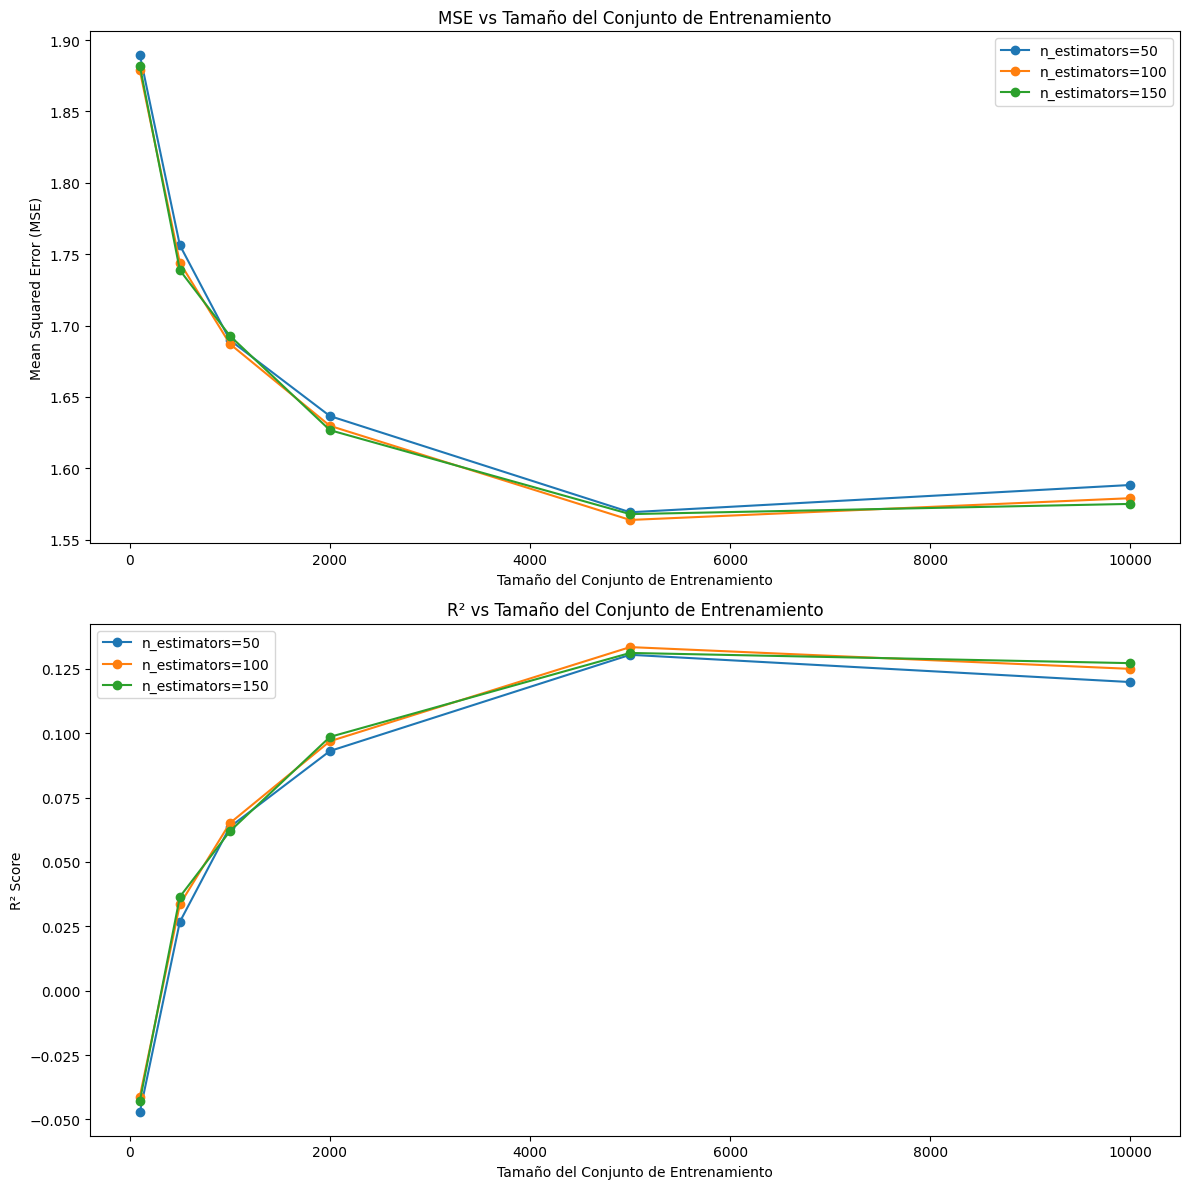

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Valores a probar para los hiperparámetros y tamaños de muestra
n_estimators_values = [50, 100, 150]
sample_sizes = [100, 500, 1000, 2000,5000,10000]

# Almacenar los resultados
results = []

# Ciclo para combinar los hiperparámetros y los tamaños de muestra
for n_estimators in n_estimators_values:
    mse_values = []
    r2_values = []

    for sample_size in sample_sizes:
        # Ajustar el tamaño del conjunto de entrenamiento
        X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train, y_train, train_size=sample_size, random_state=42)

        # Selección de características para el nuevo tamaño de muestra
        X_train_selected = k_best.fit_transform(X_train_sampled, y_train_sampled)
        X_test_selected = k_best.transform(X_test)

        # Entrenar el modelo con n_estimators
        model = RandomForestRegressor(n_estimators=n_estimators,max_depth=10, random_state=42)
        model.fit(X_train_selected, y_train_sampled)

        # Evaluar el modelo
        y_pred = model.predict(X_test_selected)

        # Calcular MSE y R²
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mse_values.append(mse)
        r2_values.append(r2)

    # Guardar los resultados para este valor de n_estimators
    results.append({'n_estimators': n_estimators, 'mse_values': mse_values, 'r2_values': r2_values})

# Graficar los resultados: MSE y R² para diferentes combinaciones de n_estimators y tamaños de muestra
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# Graficar MSE
for result in results:
    ax[0].plot(sample_sizes, result['mse_values'], label=f'n_estimators={result["n_estimators"]}', marker='o')
    ax[0].set_title("MSE vs Tamaño del Conjunto de Entrenamiento")
    ax[0].set_xlabel("Tamaño del Conjunto de Entrenamiento")
    ax[0].set_ylabel("Mean Squared Error (MSE)")
    ax[0].legend()

# Graficar R²
for result in results:
    ax[1].plot(sample_sizes, result['r2_values'], label=f'n_estimators={result["n_estimators"]}', marker='o')
    ax[1].set_title("R² vs Tamaño del Conjunto de Entrenamiento")
    ax[1].set_xlabel("Tamaño del Conjunto de Entrenamiento")
    ax[1].set_ylabel("R² Score")
    ax[1].legend()

plt.tight_layout()
plt.show()

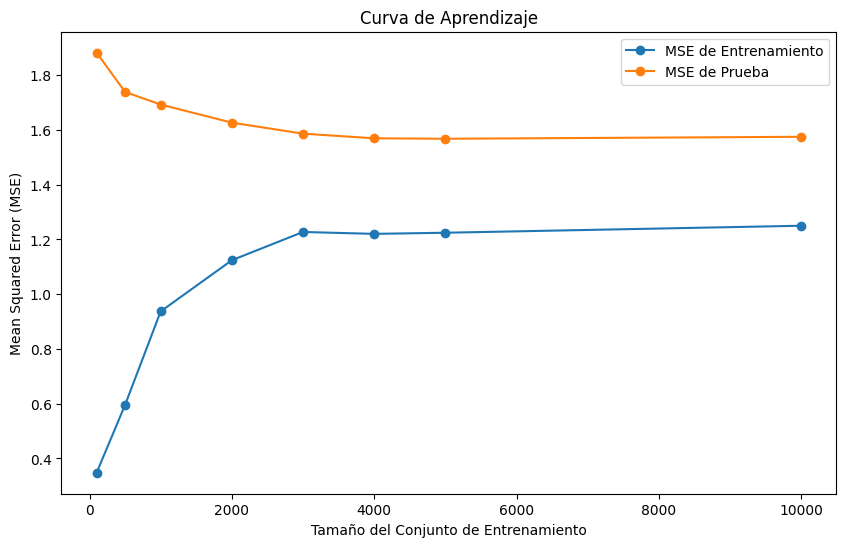

In [ ]:
#curva de aprendizaje del modelo para saber cuantos datos meter para ver si hay sobreajuste o necesito más datos
# Ciclo para calcular el MSE a medida que aumentas el tamaño del conjunto de entrenamiento
train_sizes = [100, 500, 1000, 2000, 3000, 4000, 5000,10000]
train_mse = []
test_mse = []

for train_size in train_sizes:
    # Crear conjunto de entrenamiento con el tamaño deseado
    X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)

    # Selección de características
    X_train_selected = k_best.fit_transform(X_train_sampled, y_train_sampled)
    X_test_selected = k_best.transform(X_test)

    # Entrenar el modelo
    model.fit(X_train_selected, y_train_sampled)

    # Calcular los MSE para el conjunto de entrenamiento y el de prueba
    y_train_pred = model.predict(X_train_selected)
    y_test_pred = model.predict(X_test_selected)

    train_mse.append(mean_squared_error(y_train_sampled, y_train_pred))
    test_mse.append(mean_squared_error(y_test, y_test_pred))

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mse, label="MSE de Entrenamiento", marker='o')
plt.plot(train_sizes, test_mse, label="MSE de Prueba", marker='o')
plt.title("Curva de Aprendizaje")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.show()

In [ ]:
#basicamente con 3000 muestras ya es más que suficiente porque en el compromiso tiempo de entrenamiento curva de aprendizaje no hay mucha mejora

*representaciones para ver funcionamiento correcto de random forest*

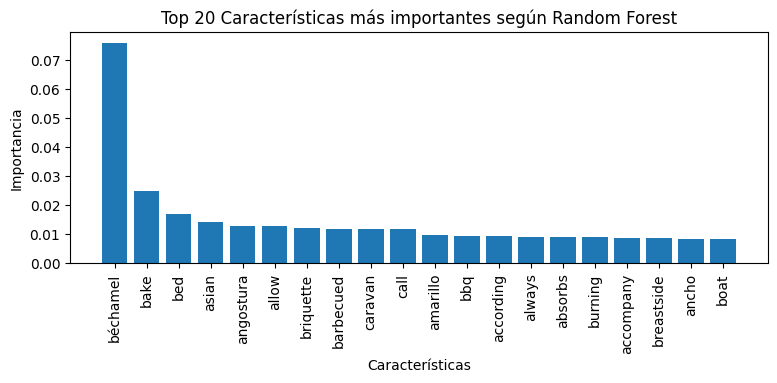

In [ ]:
# Obtener los nombres de las características del vectorizador
feature_names = tfidf.get_feature_names_out()

# Obtener las importancias de las características del modelo Random Forest
importances = model.feature_importances_

# Ordenar las características por importancia
indices = np.argsort(importances)[::-1]

# Número de características más importantes a mostrar
top_n = 20
top_indices = indices[:top_n]

# Crear un gráfico de barras
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3))
plt.title("Top 20 Características más importantes según Random Forest")#la info que aportan al árbol de división
plt.bar(range(top_n), importances[top_indices], align="center")
plt.xticks(range(top_n), [feature_names[i] for i in top_indices], rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.show()

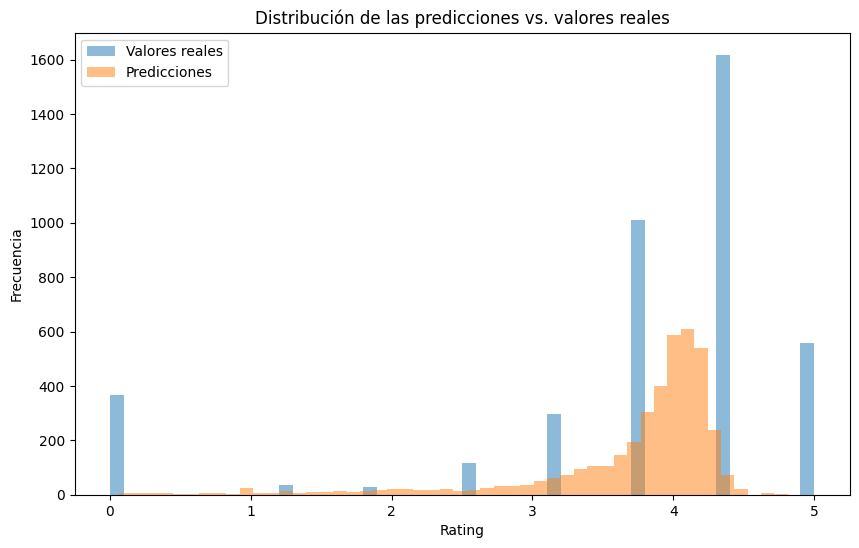

In [ ]:
#distribución valores reales rating vs predicciones
# Comparar distribuciones de las predicciones y los valores reales
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=50, alpha=0.5, label="Valores reales")
plt.hist(y_pred, bins=50, alpha=0.5, label="Predicciones")
plt.title("Distribución de las predicciones vs. valores reales")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

In [ ]:
# Reentrenar con 5000 recetas y mejores hiperparámetros
X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train, y_train, train_size=5000, random_state=42)
X_train_selected = k_best.fit_transform(X_train_sampled, y_train_sampled)
X_test_selected = k_best.transform(X_test)

# Mejor configuración
model = RandomForestRegressor(
    n_estimators=150,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    bootstrap=True,
    random_state=42
)
model.fit(X_train_selected, y_train_sampled)

# Predicciones y evaluación
y_pred = model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mejor modelo - MSE: {mse:.4f}, R²: {r2:.4f}")

Mejor modelo - MSE: 1.5739, R²: 0.1278
